In [1]:
import sys
sys.path.append('..')

In [ ]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label as nd_label
from scipy.signal import find_peaks
import shapely
from shapely import MultiPoint, Polygon, MultiPolygon
from simplification.cutil import simplify_coords_vw
from scipy.spatial import ConvexHull
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from detect_ceiling import detect_ceiling_peaks, extract_ceiling_levels, refine_all_ceiling_levels
from sklearn.model_selection import ParameterGrid
from get_dimentions import *
from get_boundary import *
from detect_floor import *
from detect_walls import *
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
FILE = "../data/alex5.ply"

In [4]:
with open('../config.yaml') as f:
    config = yaml.safe_load(f)

In [5]:
s_val = PointCloudDataset(FILE)

In [6]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

In [7]:
sem_seg.visualize_pcd()

In [8]:
# sem_seg.ransac_segment()

In [9]:
# sem_seg.ransac_segmentor.visualize_segments()

In [10]:
points = sem_seg.points[:, :3]

### BY CEILING


DETECT CEILING PEAKS
Found 3 peaks

Top 10 peaks by height:
ID    Height (m)   Points       Type           
──────────────────────────────────────────────────
0     1.153        5,612        CEILING ✓      
1     0.653        1,995        CEILING ✓      
2     -1.767       25,705       FLOOR          


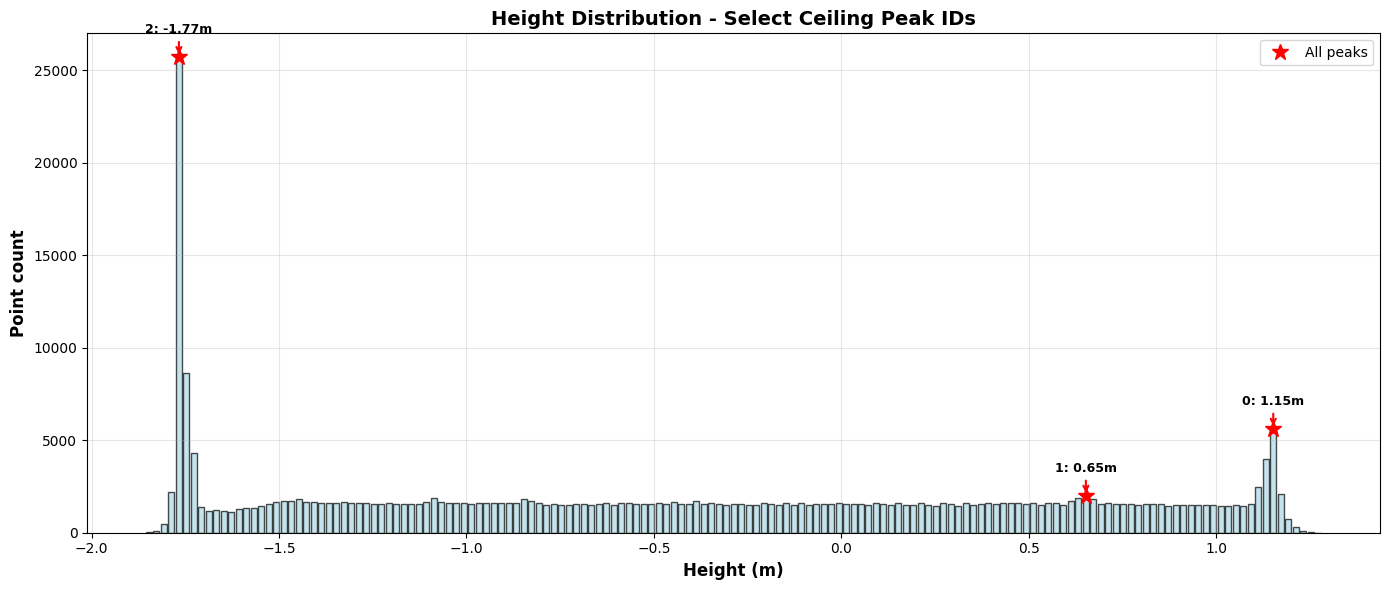


✓ Inspect the plot and choose ceiling peak IDs
  Example: If peaks 0 and 1 are ceilings, use: [0, 1]


In [11]:
step1_result = detect_ceiling_peaks(points, show_top_n=10)


EXTRACT CEILING LEVELS
✓ Ceiling level 0: 1.153m with 18,973 points
✓ Ceiling level 1: 0.653m with 16,857 points


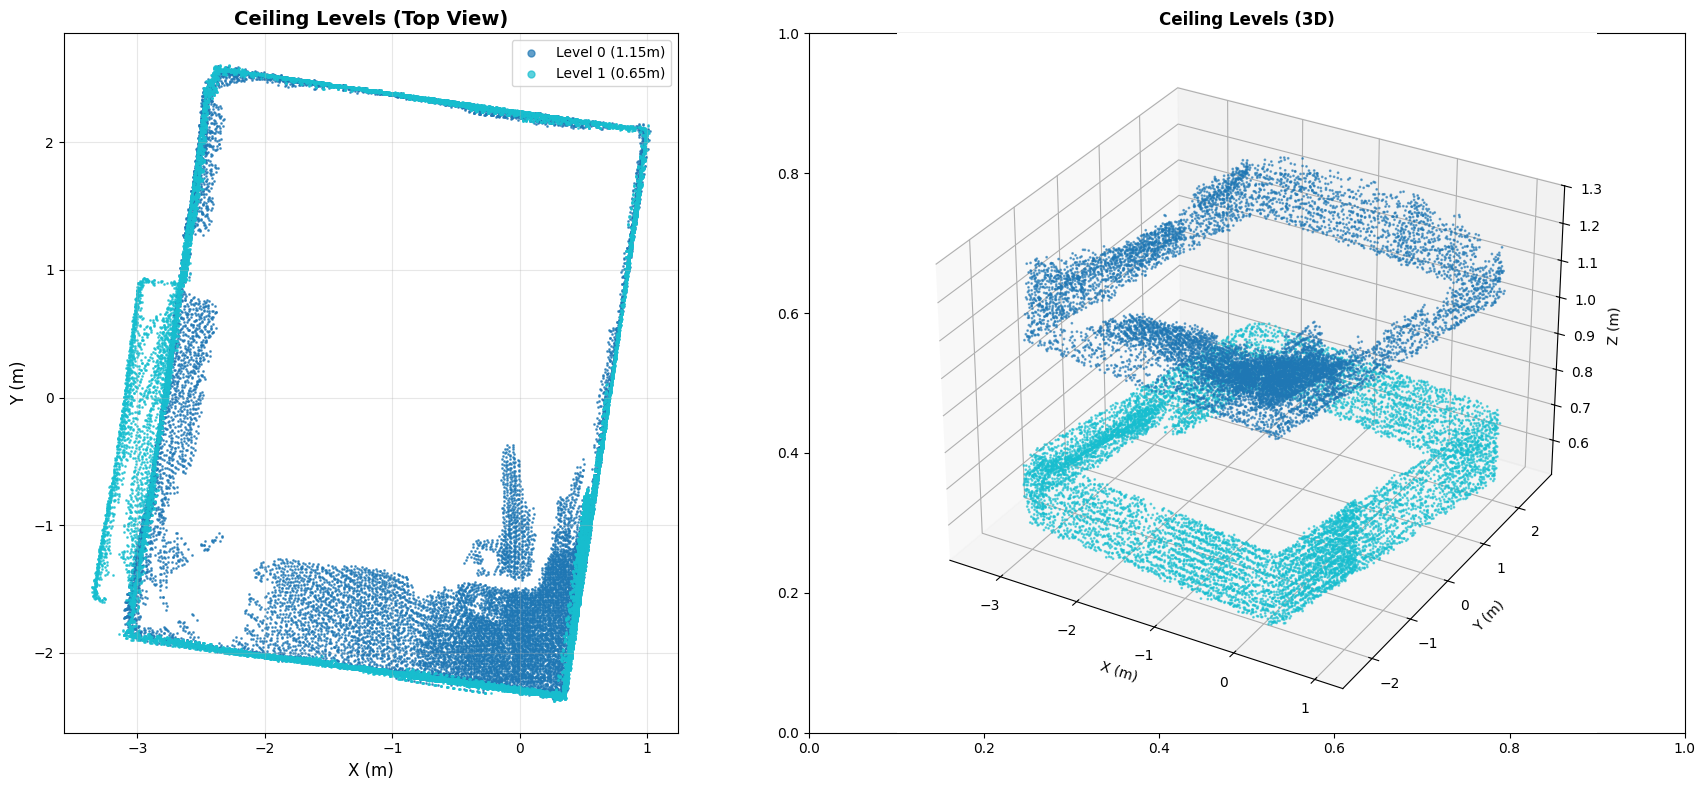


✓ Extracted 2 ceiling level(s)


In [12]:
ceiling_levels = extract_ceiling_levels(
    step1_result,
    selected_peak_ids=[0, 1],
    thickness=0.10
)

In [13]:
def detect_ceiling_correct(points, 
                          top_percentile=95,  # Look at top 5% of heights
                          thickness=0.10):
    """
    Detect ceiling by looking at HIGHEST points, not most dense cluster
    """
    
    z_coords = points[:, 2]
    
    print(f"\n{'='*70}")
    print(f"CEILING DETECTION (HEIGHT-BASED)")
    print(f"{'='*70}")
    print(f"Z range: [{z_coords.min():.3f}m, {z_coords.max():.3f}m]")
    
    # Step 1: Get top percentile
    z_threshold = np.percentile(z_coords, top_percentile)
    
    print(f"\nTop {100-top_percentile}% height threshold: {z_threshold:.3f}m")
    
    # Step 2: Extract top points
    top_mask = z_coords >= z_threshold
    top_points = points[top_mask]
    
    print(f"Points above threshold: {len(top_points):,}")
    
    if len(top_points) < 100:
        print(f"❌ Too few top points!")
        return np.array([], dtype=int)
    
    # Step 3: Find densest cluster in top points using histogram
    top_z = top_points[:, 2]
    hist, bin_edges = np.histogram(top_z, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find peak in top region
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(hist, prominence=len(top_points) * 0.05)
    
    if len(peaks) == 0:
        # No clear peak, use highest point
        ceiling_height = top_z.max()
        print(f"No clear peak, using max height: {ceiling_height:.3f}m")
    else:
        # Get HIGHEST peak (ceiling is at top!)
        peak_heights = bin_centers[peaks]
        ceiling_height = peak_heights.max()
        print(f"Found {len(peaks)} peaks in top region")
        print(f"Highest peak at: {ceiling_height:.3f}m")
    
    # Step 4: Extract ceiling points (within thickness)
    ceiling_mask = np.abs(z_coords - ceiling_height) <= thickness
    ceiling_indices = np.where(ceiling_mask)[0]
    
    print(f"\nCeiling height: {ceiling_height:.3f}m")
    print(f"Ceiling points: {len(ceiling_indices):,} ({100*len(ceiling_indices)/len(points):.1f}%)")
    
    return ceiling_indices
    

In [14]:
ceiling_indices = detect_ceiling_correct(points)


CEILING DETECTION (HEIGHT-BASED)
Z range: [-1.857m, 1.281m]

Top 5% height threshold: 1.116m
Points above threshold: 13,828
Found 1 peaks in top region
Highest peak at: 1.147m

Ceiling height: 1.147m
Ceiling points: 19,341 (7.0%)


In [11]:
all_ceiling_points = np.vstack([i["points"] for i in ceiling_levels])

In [12]:
ceiling_points_2d = all_ceiling_points[:, :2]

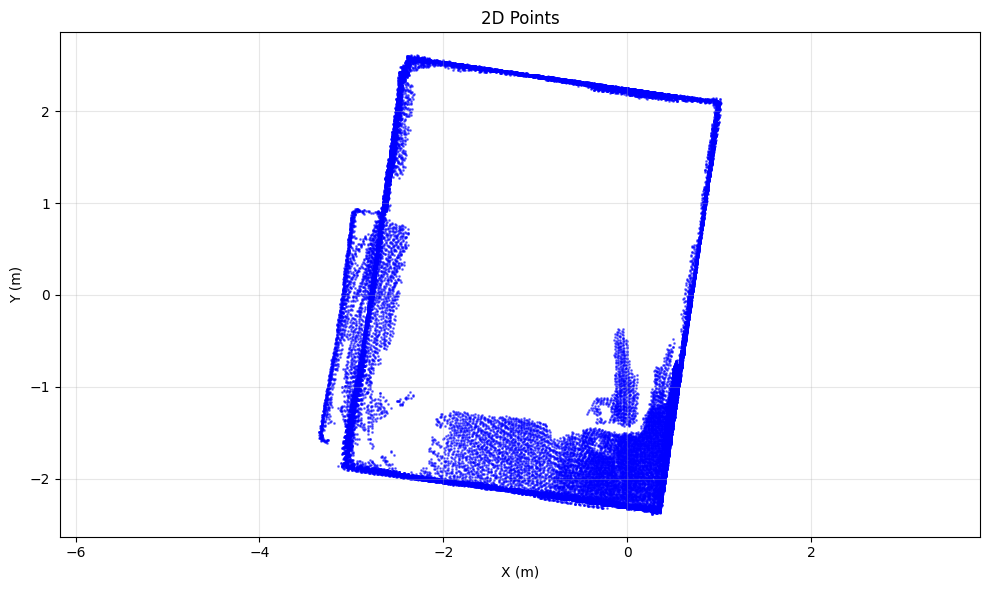

In [13]:
visualize_2d_points(ceiling_points_2d, downsample=1)

In [14]:
refined_ceiling_levels = refine_all_ceiling_levels(
    ceiling_levels,
    distance_threshold=0.1
)


REFINING ALL CEILING LEVELS

--- Level 0 (Height: 1.153m) ---

RANSAC PLANE REFINEMENT
Input points: 18,973
Distance threshold: 0.1m

✓ Plane equation: 0.0022x + -0.0007y + 1.0000z + -1.1345 = 0
✓ Inliers: 18,518 / 18,973 (97.6%)
✓ Outliers removed: 455 (2.4%)

--- Level 1 (Height: 0.653m) ---

RANSAC PLANE REFINEMENT
Input points: 16,857
Distance threshold: 0.1m

✓ Plane equation: 0.0027x + 0.0065y + 1.0000z + -0.6390 = 0
✓ Inliers: 14,752 / 16,857 (87.5%)
✓ Outliers removed: 2,105 (12.5%)

REFINEMENT SUMMARY
Level 0 @ 1.15m:
  Original: 18,973 points
  Cleaned:  18,518 points
  Removed:  455 (2.4%)
Level 1 @ 0.65m:
  Original: 16,857 points
  Cleaned:  14,752 points
  Removed:  2,105 (12.5%)

Total across all levels:
  Original: 35,830 points
  Cleaned:  33,270 points
  Removed:  2,560 (7.1%)


In [15]:
all_clean_ceiling_points = np.vstack([
    level['points'] for level in refined_ceiling_levels
])

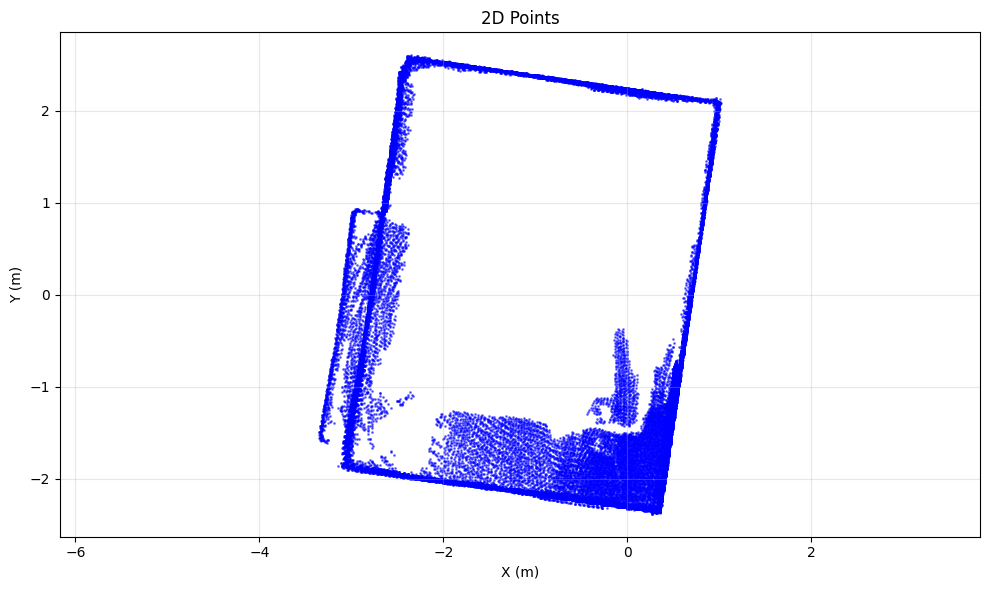

In [16]:
ceiling_points_2d = all_clean_ceiling_points[: , :2]

visualize_2d_points(ceiling_points_2d)

### BY WALL

In [17]:
ceiling_indices = np.hstack([level["indices"] for level in refined_ceiling_levels])

In [15]:
ceiling_indices

array([     9,     24,     26, ..., 276473, 276483, 276534],
      shape=(19341,))

In [16]:
segmentation = segment_floor_ceiling_walls(
    points,
    ceiling_indices=ceiling_indices,
    floor_method='histogram_ransac',
    bottom_slice_height=0.50,
    floor_ransac_threshold=0.02
)


  Running RANSAC on bottom slice only...
    ✓ Plane is horizontal
    RANSAC inliers in slice: 32,662
    Expanded to all points (±0.1m): 44,908
    Additional floor points found: 12,246

Room height:    2.896m (floor: -1.764m, ceiling: 1.132m)


In [ ]:
segmentation["ceiling_points"][]

array([[-0.200682  , -1.922718  ,  1.150063  ],
       [ 0.467167  , -0.847915  ,  1.124804  ],
       [ 0.50079   ,  2.149891  ,  1.060823  ],
       ...,
       [-2.868784  , -0.544561  ,  1.119483  ],
       [ 0.27350767, -1.247052  ,  1.12506433],
       [ 0.526707  , -1.02487   ,  1.133748  ]], shape=(19341, 3))

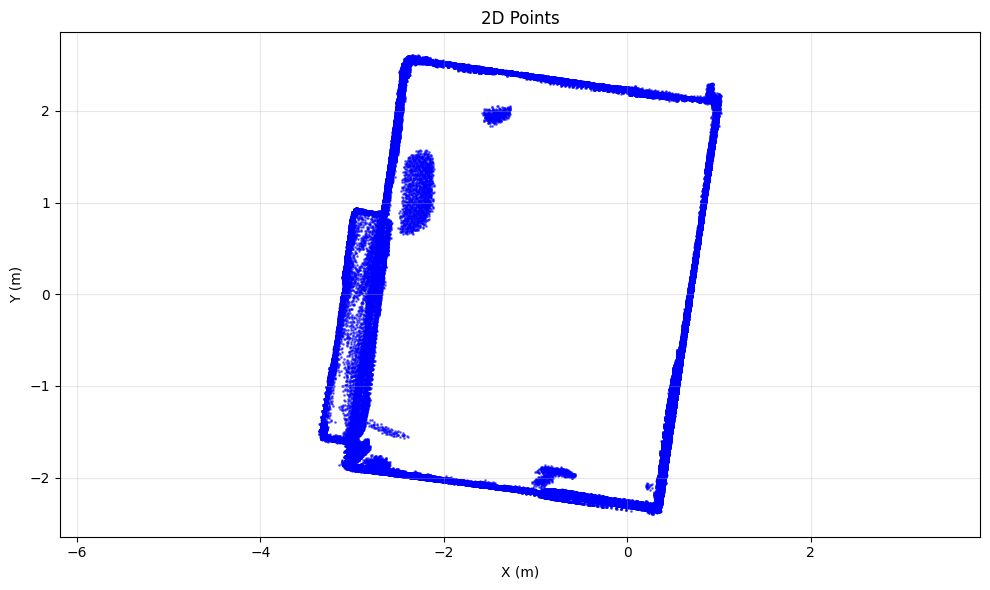

In [22]:
visualize_2d_points(segmentation["wall_points"][:, :2])

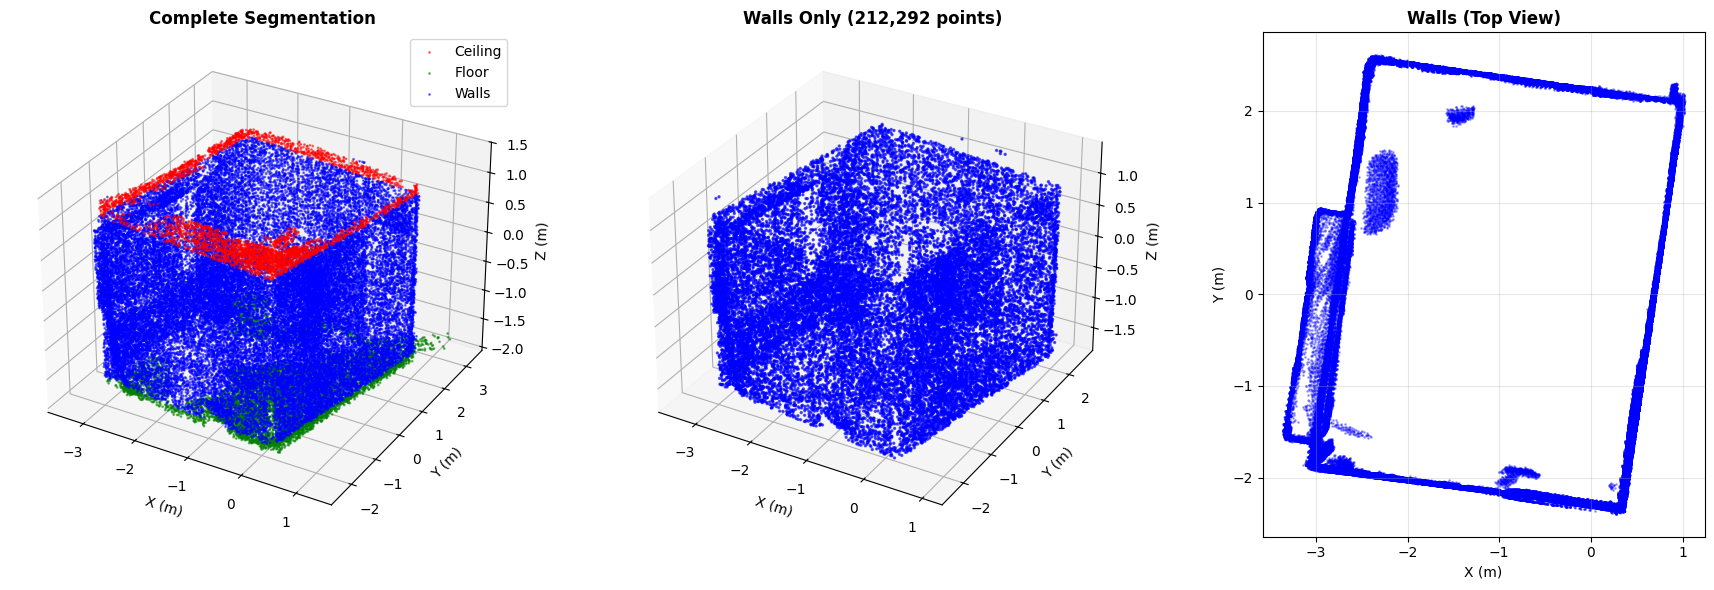

In [23]:
visualize_segmentation(points, segmentation, subsample=50000)

In [26]:
floor_height, ceiling_height = segmentation["floor_height"], segmentation["ceiling_height"]

In [27]:
floor_height, ceiling_height

(np.float64(-1.7637943280933528), np.float64(1.1324267060608335))

In [30]:
ceiling_height - floor_height

np.float64(2.8962210341541863)

In [31]:
wall_result = extract_walls_complete_pipeline(
    points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    floor_margin=0.10,        # 10cm margin
    ceiling_margin=0.25,      # 10cm margin
    normal_radius=0.10,       # 10cm for normal estimation
    max_nn=30,
    vertical_threshold=0.15   # |normal_z| < 0.15 = vertical
)

  Excluded: 76,718 points (27.7%)


In [32]:
vertical_points = wall_result["wall_points"]
vertical_normals = wall_result["wall_normals"]

In [33]:
# visualize_wall_points_3d(vertical_points, vertical_normals)

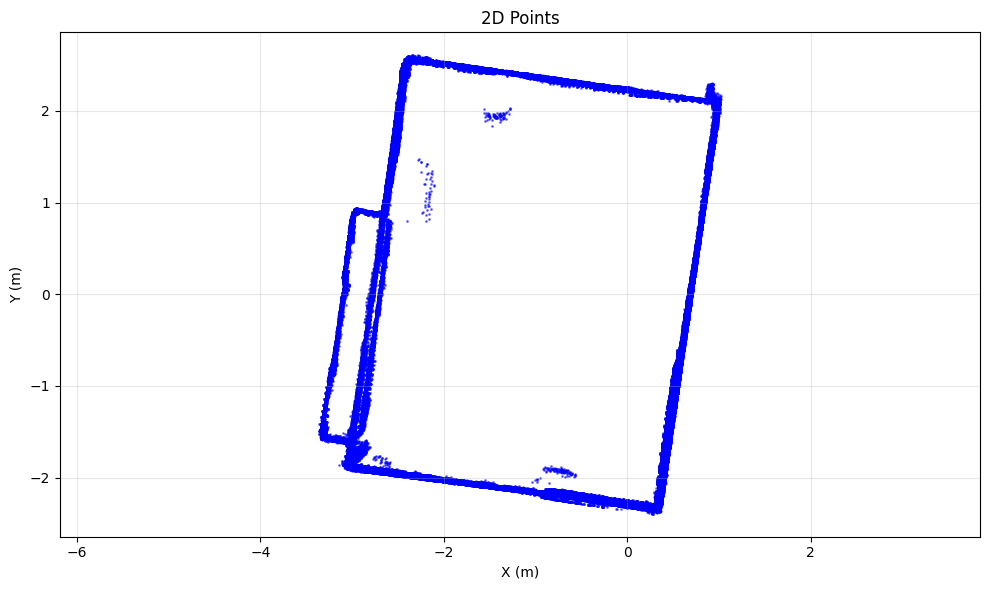

In [34]:
wall_points_2d = vertical_points[: , :2]
visualize_2d_points(wall_points_2d)

In [35]:
walls = detect_walls_ransac_clustering(
    vertical_points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    distance_threshold=0.03,      # 3cm RANSAC
    cluster_eps=0.12,             # 12cm clustering
    min_cluster_points=50,       # At least 100 points
    min_wall_height=1.8,          # ← Increased! At least 1.8m tall
    min_wall_length=0.10,         # ← Increased! At least 80cm long
    max_wall_thickness=0.25,      # Max 25cm thick
    min_height_ratio=0.60,        # Must span 60% of room height
    max_iterations=30
)

In [36]:
wall_points = get_room_wall_points(walls)

In [37]:
wall_points_2d = project_points_to_2d(wall_points)

Projected 126881 points to 2D
2D bounds:
  X: [-3.145, 1.013] (range: 4.158m)
  Y: [-2.381, 2.602] (range: 4.983m)


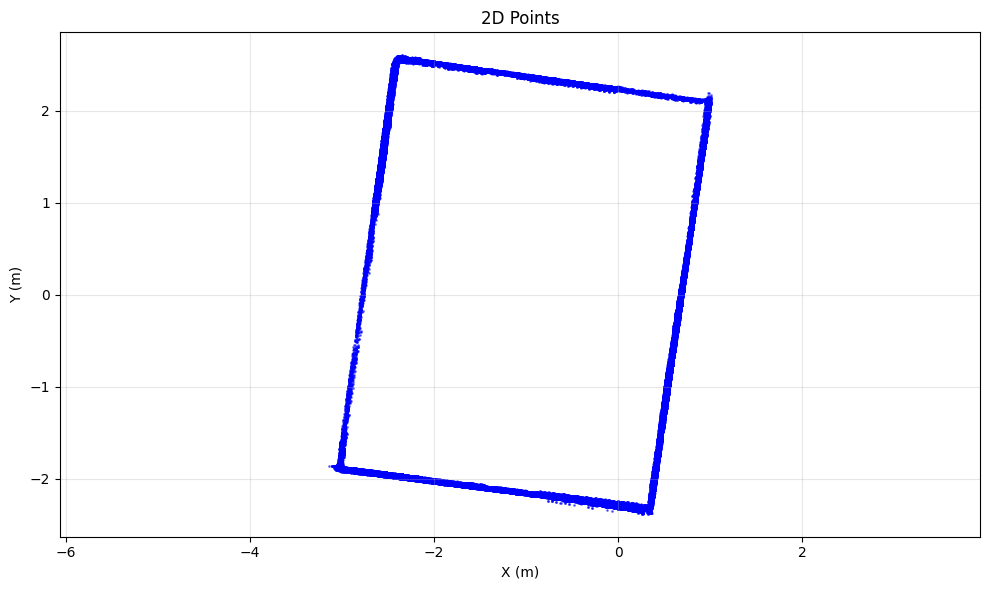

In [38]:
visualize_2d_points(wall_points_2d)

### workflow

In [39]:
median_thickness = compute_median_wall_thickness(walls)


WALL THICKNESS ANALYSIS
Walls analyzed: 5
Median thickness: 0.077m (7.7cm)
Mean thickness: 0.073m (7.3cm)
Range: 0.056m - 0.084m


In [241]:
def finetune_params(wall_points_2d, median_thickness, concave_ratio, simplification_method, tolerance):
    try:
        boundary_polygon = extract_room_boundary_from_walls(
            wall_points_2d,
            method='concave_hull',
            concave_ratio=concave_ratio
        )
        
        # Check if boundary is valid
        if boundary_polygon is None or boundary_polygon.is_empty:
            return np.nan, np.nan
        
        offset_boundary = offset_boundary_inward(
            boundary_polygon,
            offset_distance=median_thickness / 3
        )
        
        # Handle MultiPolygon case - take the largest polygon
        if isinstance(offset_boundary, MultiPolygon):
            # If we get multiple polygons, take the largest one by area
            offset_boundary = max(offset_boundary.geoms, key=lambda p: p.area)
        
        # Check if the result is valid
        if offset_boundary.is_empty or not isinstance(offset_boundary, Polygon):
            return np.nan, np.nan
        
        if simplification_method == "dp":
            simplified_boundary = offset_boundary.simplify(tolerance, preserve_topology=True)
        else:
            simplified_points = simplify_coords_vw(np.array(offset_boundary.exterior.coords), tolerance)
            
            # Check if we have enough points to form a polygon (at least 4 including closing point)
            if len(simplified_points) < 4:
                return np.nan, np.nan
            
            simplified_boundary = Polygon(simplified_points)
        
        # Check if simplified boundary is valid and has enough points
        if simplified_boundary.is_empty or len(simplified_boundary.exterior.coords) < 4:
            return np.nan
        
        return simplified_boundary.length, simplified_boundary.area
    
    except (ValueError, Exception) as e:
        # Catch any geometry errors and return NaN
        return np.nan, np.nan

In [242]:
def run_grid(grid, optimize, ground_truth, split=0.7):
    """
    Grid search with proper error calculation
    
    Parameters:
    -----------
    grid : list of dict
        Parameter combinations
    optimize : str
        'area', 'perimeter', or 'both'
    ground_truth : dict
        {'perimeter': float, 'area': float}
    split : float
        Weight for perimeter when optimize='both'
        Default 0.7 = 70% perimeter, 30% area
    
    Returns:
    --------
    results : dict
        Best configuration and all results
    """
    
    best_score = np.inf
    best_pred_perimeter = 0.0
    best_pred_area = 0.0
    best_params = {}
    all_results = []
    
    print(f"Optimization: {optimize}")
    if optimize == "both":
        print(f"Weights: Perimeter={split:.1%}, Area={1-split:.1%}")
    
    for i, params in tqdm(enumerate(grid, 1)):
        # Extract boundary with current params
        pred_perimeter, pred_area = finetune_params(
            wall_points_2d,
            median_thickness,
            params["alpha"],
            params["simplification"][0],
            params["simplification"][1]
        )
        
        # Skip invalid results
        if np.isnan(pred_perimeter) or np.isnan(pred_area):
            print(f"[{i}/{len(grid)}] SKIPPED (invalid result)")
            continue
        
        # Calculate percentage errors for each metric
        perimeter_error_pct = abs(pred_perimeter - ground_truth['perimeter']) / ground_truth['perimeter'] * 100
        area_error_pct = abs(pred_area - ground_truth['area']) / ground_truth['area'] * 100
        
        # Calculate score based on optimization target
        if optimize == "area":
            score = area_error_pct
            
        elif optimize == "perimeter":
            score = perimeter_error_pct
            
        elif optimize == "both":
            # Weighted combination of percentage errors
            score = split * perimeter_error_pct + (1 - split) * area_error_pct
        
        else:
            raise ValueError(f"Unknown optimize: {optimize}")
        
        # Store result
        result = {
            'params': params,
            'pred_perimeter': pred_perimeter,
            'pred_area': pred_area,
            'perimeter_error_pct': perimeter_error_pct,
            'area_error_pct': area_error_pct,
            'combined_error': score
        }
        all_results.append(result)
        
        # Print progress
        simp_str = f"{params['simplification'][0]}"
        if params['simplification'][0] != 'none':
            simp_str += f"({params['simplification'][1]})"
        
        
        # Update best
        if score < best_score:
            best_score = score
            best_pred_perimeter = pred_perimeter
            best_pred_area = pred_area
            best_params = params
    
    
    best_perim_error = abs(best_pred_perimeter - ground_truth['perimeter']) / ground_truth['perimeter'] * 100
    best_area_error = abs(best_pred_area - ground_truth['area']) / ground_truth['area'] * 100

    
    return {
        "best_score": best_score,
        "best_pred_perimeter": best_pred_perimeter,
        "best_pred_area": best_pred_area,
        "best_params": best_params,
        "all_results": all_results
    }

In [243]:
param_grid = {
    'alpha': [0.085, 0.20, 0.30, 0.40, 0.50],
    'simplification': [('vw', 0.01),
                        ('vw', 0.03),
                        ('vw', 0.05),
                        ('vw', 0.07),
                       ('vw', 0.1),
                       ('vw', 0.2),
                       ('vw', 0.3),
                       ('vw', 0.4),
                       ('vw', 0.5),
                       ('dp', 0.1),
                       ('dp', 0.2),

]}
grid = ParameterGrid(param_grid)

In [244]:
a, b, c, d = (900 + 2410 + 110) / 1000, 4485 / 1000, 3420 / 1000, 4485 / 1000
p = a + b + c + d 
S = 15.34

In [245]:
p, a

(15.809999999999999, 3.42)

In [246]:
result = run_grid(
    grid=grid,
    optimize="both",
    ground_truth={'perimeter': p, 'area': S},
    split=0.5
)

Optimization: both
Weights: Perimeter=50.0%, Area=50.0%


55it [00:16,  3.32it/s]


In [247]:
result

{'best_score': 0.07323220083841826,
 'best_pred_perimeter': 15.808313275713484,
 'best_pred_area': 15.319168942095558,
 'best_params': {'alpha': 0.085, 'simplification': ('vw', 0.2)},
 'all_results': [{'params': {'alpha': 0.085, 'simplification': ('vw', 0.01)},
   'pred_perimeter': 15.942756610423682,
   'pred_area': 15.410100546342761,
   'perimeter_error_pct': 0.8397002556842739,
   'area_error_pct': 0.45697878971813105,
   'combined_error': 0.6483395227012024},
  {'params': {'alpha': 0.085, 'simplification': ('vw', 0.03)},
   'pred_perimeter': 15.857515314831517,
   'pred_area': 15.403718513571773,
   'perimeter_error_pct': 0.3005396257528017,
   'area_error_pct': 0.41537492550047767,
   'combined_error': 0.3579572756266397},
  {'params': {'alpha': 0.085, 'simplification': ('vw', 0.05)},
   'pred_perimeter': 15.857515314831517,
   'pred_area': 15.403718513571773,
   'perimeter_error_pct': 0.3005396257528017,
   'area_error_pct': 0.41537492550047767,
   'combined_error': 0.3579572756

In [248]:
boundary_polygon = extract_room_boundary_from_walls(
    wall_points_2d,
    method='concave_hull',
    concave_ratio=result["best_params"]["alpha"]
)

In [272]:
# thickness from RANSAC step
offset_implicit = offset_boundary_inward(
    boundary_polygon,
    offset_distance=median_thickness / 3
)

In [273]:
# buffer_smooth=0.05
offset_implicit = offset_implicit.buffer(10, join_style=2).buffer(-10.0, join_style=2)

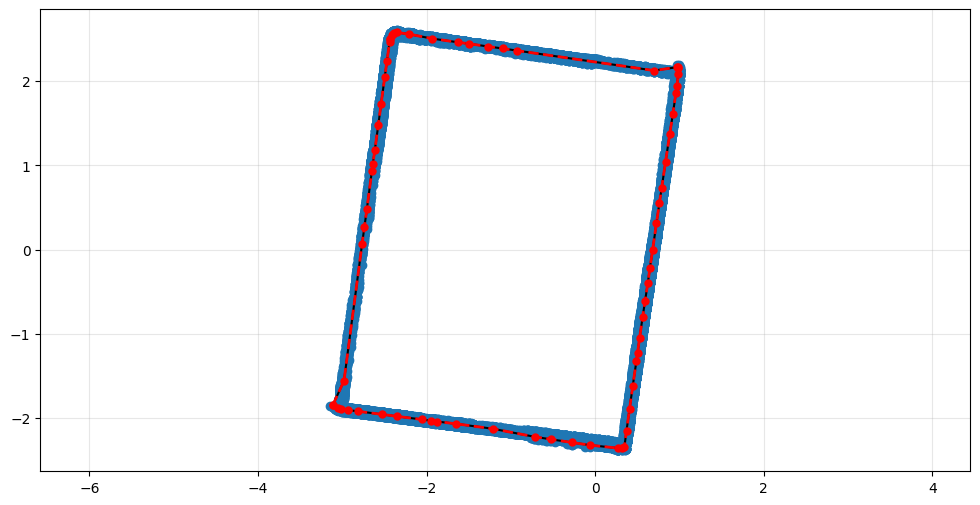

In [274]:

plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

if offset_implicit.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = offset_implicit.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


POLYGON DIMENSIONS
Number of corners: 4
Wall  1: Corner 1 → Corner 2, Length:  4.488m, Angle:   80.2°
Wall  2: Corner 2 → Corner 3, Length:  3.351m, Angle:  352.9°
Wall  3: Corner 3 → Corner 4, Length:  4.555m, Angle:  262.1°
Wall  4: Corner 4 → Corner 1, Length:  3.495m, Angle:  171.8°

──────────────────────────────────────────────────────────────────────
Total perimeter: 15.889m
Total area:      15.470m²


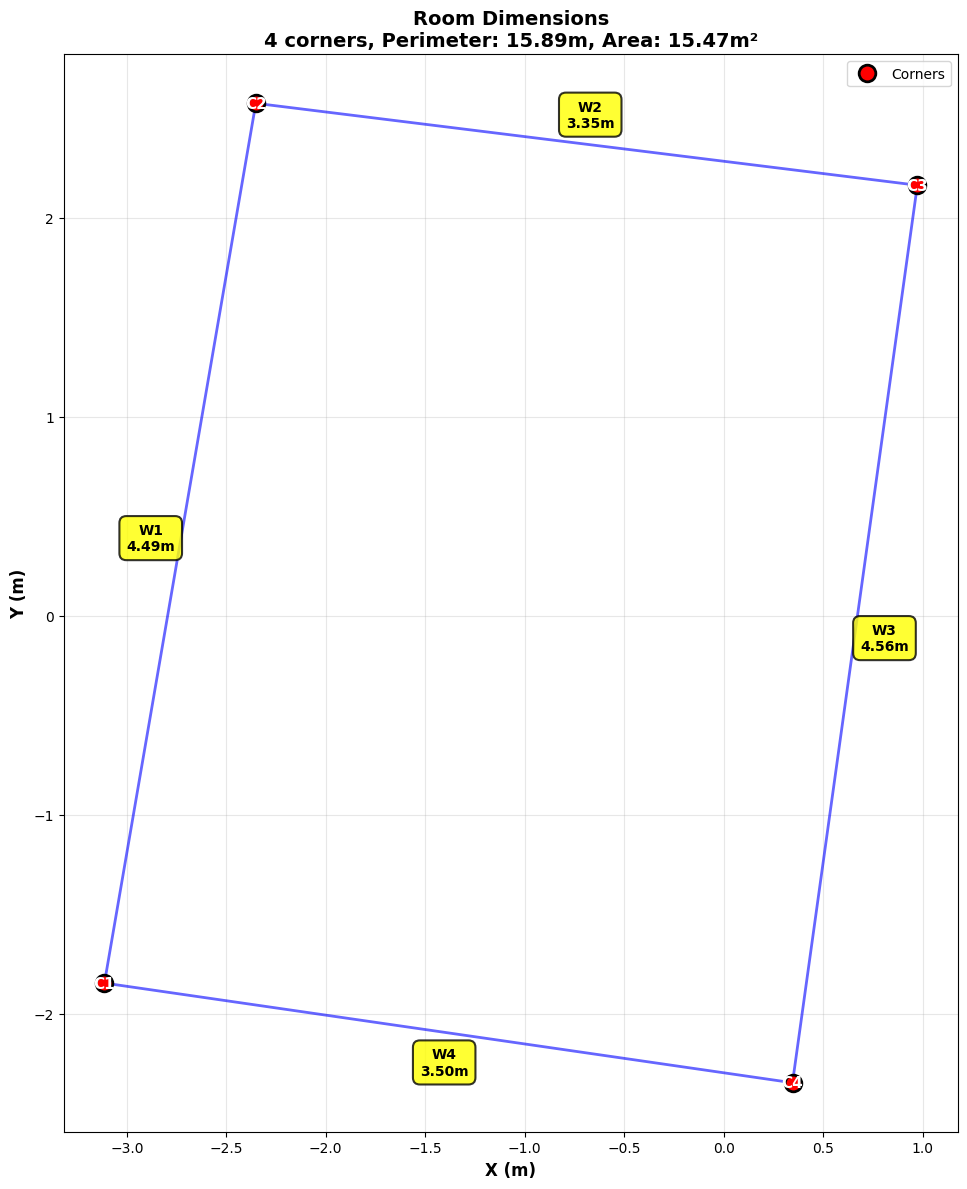

In [275]:
if result["best_params"]["simplification"][0] == "dp":
    simplified_boundary = offset_implicit.simplify(result["best_params"]["simplification"][1], preserve_topology=True)
    dimensions = compute_polygon_dimensions(simplified_boundary)
    visualize_polygon_dimensions(simplified_boundary, dimensions)
else:
    simplified_points = simplify_coords_vw(np.array(offset_implicit.exterior.coords),
                                       epsilon=result["best_params"]["simplification"][1])
    dimensions = compute_polygon_dimensions(Polygon(simplified_points))
    visualize_polygon_dimensions(Polygon(simplified_points), dimensions)

In [47]:
def merge_nearby_vertices_simple(polygon_points, distance_threshold=0.10):
    """
    Merge consecutive vertices that are very close together
    
    This preserves perimeter accuracy while reducing vertex count!
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Polygon vertices in order
    distance_threshold : float
        Merge vertices closer than this (meters)
    
    Returns:
    --------
    merged_points : np.ndarray (M, 2)
        Simplified polygon (M ≤ N)
    """
    
    print(f"\n{'='*70}")
    print(f"SIMPLE VERTEX MERGING")
    print(f"{'='*70}")
    print(f"Input vertices: {len(polygon_points)}")
    print(f"Distance threshold: {distance_threshold}m")
    
    if len(polygon_points) < 3:
        return polygon_points
    
    merged = [polygon_points[0]]
    
    for i in range(1, len(polygon_points)):
        current = polygon_points[i]
        previous = merged[-1]
        
        distance = np.linalg.norm(current - previous)
        
        if distance >= distance_threshold:
            # Far enough, keep this vertex
            merged.append(current)
        else:
            # Too close, skip (merge with previous)
            print(f"  Merging vertex {i} with previous (distance: {distance:.3f}m)")
    
    # Check wrap-around (last to first)
    if len(merged) > 1:
        distance_to_start = np.linalg.norm(merged[-1] - merged[0])
        if distance_to_start < distance_threshold:
            print(f"  Merging last vertex with first (distance: {distance_to_start:.3f}m)")
            merged = merged[:-1]
    
    merged_points = np.array(merged)
    
    print(f"\n✓ Result: {len(polygon_points)} → {len(merged_points)} vertices")
    
    # Check perimeter preservation
    from shapely.geometry import Polygon
    original_perim = Polygon(polygon_points).length
    merged_perim = Polygon(merged_points).length
    
    print(f"\nPerimeter check:")
    print(f"  Original: {original_perim:.3f}m")
    print(f"  Merged:   {merged_perim:.3f}m")
    print(f"  Diff:     {abs(original_perim - merged_perim):.3f}m "
          f"({100*abs(original_perim - merged_perim)/original_perim:.2f}%)")
    
    return merged_points

In [48]:
merged_points = merge_nearby_vertices_simple(simplified_points)


SIMPLE VERTEX MERGING
Input vertices: 7
Distance threshold: 0.1m
  Merging vertex 5 with previous (distance: 0.091m)
  Merging last vertex with first (distance: 0.000m)

✓ Result: 7 → 5 vertices

Perimeter check:
  Original: 16.681m
  Merged:   16.672m
  Diff:     0.009m (0.05%)


In [50]:
def merge_collinear_walls(dimensions, 
                         angle_tolerance=5.0,
                         max_gap=0.10):
    """
    Merge walls that are collinear (on same line)
    
    Strategy:
    1. Find pairs of consecutive walls with similar angles
    2. Check if they're collinear (approximately on same line)
    3. Merge them into single wall
    4. Repeat until no more merges possible
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions from compute_polygon_dimensions()
    angle_tolerance : float
        Max angle difference to consider collinear (degrees)
    max_gap : float
        Maximum gap between walls to merge (meters)
    
    Returns:
    --------
    merged_dimensions : list of dict
        Merged wall dimensions
    """
    
    print(f"\n{'='*70}")
    print(f"MERGING COLLINEAR WALLS")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Angle tolerance: {angle_tolerance}°")
    print(f"Max gap: {max_gap}m")
    
    merged = []
    skip_indices = set()
    
    i = 0
    while i < len(dimensions):
        if i in skip_indices:
            i += 1
            continue
        
        # Start new merged segment
        current = dimensions[i]
        merge_chain = [i]
        
        # Try to extend forward
        j = i + 1
        while j < len(dimensions):
            if j in skip_indices:
                j += 1
                continue
            
            next_wall = dimensions[j]
            
            # Check angle similarity
            angle_diff = abs(current['angle'] - next_wall['angle'])
            # Handle wrap-around (e.g., 359° and 1°)
            angle_diff = min(angle_diff, 360 - angle_diff)
            
            if angle_diff <= angle_tolerance:
                # Check gap
                gap = np.linalg.norm(current['end_point'] - next_wall['start_point'])
                
                if gap <= max_gap:
                    # Merge!
                    merge_chain.append(j)
                    current = next_wall  # Continue from this wall
                    j += 1
                else:
                    # Gap too large
                    break
            else:
                # Angle too different
                break
        
        # Create merged wall from chain
        if len(merge_chain) == 1:
            # No merge, keep original
            merged.append(dimensions[i])
        else:
            # Merge multiple walls
            first_wall = dimensions[merge_chain[0]]
            last_wall = dimensions[merge_chain[-1]]
            
            # New wall from first start to last end
            merged_start = first_wall['start_point']
            merged_end = last_wall['end_point']
            merged_vec = merged_end - merged_start
            merged_length = np.linalg.norm(merged_vec)
            merged_angle = np.degrees(np.arctan2(merged_vec[1], merged_vec[0])) % 360
            
            # Sum of individual lengths (for comparison)
            total_length = sum(dimensions[idx]['length'] for idx in merge_chain)
            
            merged_wall = {
                'wall_id': len(merged) + 1,
                'start_point': merged_start,
                'end_point': merged_end,
                'length': merged_length,
                'angle': merged_angle,
                'merged_from': merge_chain,
                'num_segments': len(merge_chain)
            }
            
            merged.append(merged_wall)
            
            print(f"  Merged {len(merge_chain)} walls (indices {merge_chain[0]}-{merge_chain[-1]}): "
                  f"{total_length:.2f}m → {merged_length:.2f}m")
            
            # Mark as processed
            skip_indices.update(merge_chain)
        
        i += 1
    
    print(f"\n✓ Result: {len(dimensions)} → {len(merged)} walls")
    
    # Renumber
    for idx, wall in enumerate(merged, 1):
        wall['wall_id'] = idx
    
    return merged


def merge_short_walls(dimensions, min_wall_length=0.30):
    """
    Merge very short walls with their neighbors
    
    Strategy:
    - Find walls shorter than threshold
    - Merge with neighbor (prefer same angle)
    - Repeat
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions
    min_wall_length : float
        Walls shorter than this get merged (meters)
    
    Returns:
    --------
    merged : list of dict
        Dimensions with short walls merged
    """
    
    print(f"\n{'='*70}")
    print(f"MERGING SHORT WALLS")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Min wall length: {min_wall_length}m")
    
    # Convert to list for easier manipulation
    walls = list(dimensions)
    
    iterations = 0
    max_iterations = 50
    
    while iterations < max_iterations:
        iterations += 1
        
        # Find shortest wall
        shortest_idx = None
        shortest_length = float('inf')
        
        for i, wall in enumerate(walls):
            if wall['length'] < min_wall_length and wall['length'] < shortest_length:
                shortest_idx = i
                shortest_length = wall['length']
        
        if shortest_idx is None:
            # No more short walls
            break
        
        # Merge with neighbor
        n = len(walls)
        prev_idx = (shortest_idx - 1) % n
        next_idx = (shortest_idx + 1) % n
        
        short_wall = walls[shortest_idx]
        prev_wall = walls[prev_idx]
        next_wall = walls[next_idx]
        
        # Decide which neighbor to merge with (prefer similar angle)
        angle_diff_prev = abs(short_wall['angle'] - prev_wall['angle'])
        angle_diff_prev = min(angle_diff_prev, 360 - angle_diff_prev)
        
        angle_diff_next = abs(short_wall['angle'] - next_wall['angle'])
        angle_diff_next = min(angle_diff_next, 360 - angle_diff_next)
        
        if angle_diff_prev < angle_diff_next:
            # Merge with previous
            merge_with = prev_idx
            keep_idx = prev_idx
            remove_idx = shortest_idx
        else:
            # Merge with next
            merge_with = shortest_idx
            keep_idx = shortest_idx
            remove_idx = next_idx
        
        # Create merged wall
        if merge_with == prev_idx:
            merged_start = prev_wall['start_point']
            merged_end = short_wall['end_point']
        else:
            merged_start = short_wall['start_point']
            merged_end = next_wall['end_point']
        
        merged_vec = merged_end - merged_start
        merged_length = np.linalg.norm(merged_vec)
        merged_angle = np.degrees(np.arctan2(merged_vec[1], merged_vec[0])) % 360
        
        walls[keep_idx] = {
            'wall_id': keep_idx + 1,
            'start_point': merged_start,
            'end_point': merged_end,
            'length': merged_length,
            'angle': merged_angle
        }
        
        # Remove the other wall
        walls.pop(remove_idx)
        
        print(f"  Iteration {iterations}: Merged wall {remove_idx+1} ({shortest_length:.2f}m) → "
              f"New length: {merged_length:.2f}m")
    
    print(f"\n✓ Result: {len(dimensions)} → {len(walls)} walls")
    
    # Renumber
    for idx, wall in enumerate(walls, 1):
        wall['wall_id'] = idx
    
    return walls


def merge_walls_complete(dimensions, 
                        angle_tolerance=8.0,
                        max_gap=0.15,
                        min_wall_length=0.50):
    """
    Complete wall merging pipeline
    
    Step 1: Merge collinear walls
    Step 2: Merge short walls with neighbors
    Step 3: Repeat until stable
    """
    
    print(f"\n{'='*70}")
    print(f"COMPLETE WALL MERGING PIPELINE")
    print(f"{'='*70}")
    print(f"Initial walls: {len(dimensions)}")
    
    current = dimensions
    prev_count = len(current)
    
    for iteration in range(5):  # Max 5 rounds
        print(f"\n{'-'*70}")
        print(f"ROUND {iteration + 1}")
        print(f"{'-'*70}")
        
        # Step 1: Merge collinear
        current = merge_collinear_walls(
            current,
            angle_tolerance=angle_tolerance,
            max_gap=max_gap
        )
        
        # Step 2: Merge short
        current = merge_short_walls(
            current,
            min_wall_length=min_wall_length
        )
        
        # Check if stable
        new_count = len(current)
        if new_count == prev_count:
            print(f"\n✓ Converged after {iteration + 1} rounds")
            break
        
        prev_count = new_count
    
    print(f"\n{'='*70}")
    print(f"MERGING COMPLETE")
    print(f"{'='*70}")
    print(f"Final walls: {len(current)}")
    print(f"Reduction: {len(dimensions)} → {len(current)} "
          f"({100*(len(dimensions)-len(current))/len(dimensions):.1f}%)")
    
    return current

In [79]:
merged_dimensions = merge_walls_complete(
    dimensions,
    angle_tolerance=60.0,      # Walls within 8° are considered same direction
    max_gap=0.15,             # Walls < 15cm apart can merge
    min_wall_length=0.25     # Walls < 50cm get merged with neighbors
)


COMPLETE WALL MERGING PIPELINE
Initial walls: 6

----------------------------------------------------------------------
ROUND 1
----------------------------------------------------------------------

MERGING COLLINEAR WALLS
Input walls: 6
Angle tolerance: 60.0°
Max gap: 0.15m
  Merged 2 walls (indices 4-5): 4.27m → 4.26m

✓ Result: 6 → 5 walls

MERGING SHORT WALLS
Input walls: 5
Min wall length: 0.25m
  Iteration 1: Merged wall 1 (0.24m) → New length: 4.50m

✓ Result: 5 → 4 walls

----------------------------------------------------------------------
ROUND 2
----------------------------------------------------------------------

MERGING COLLINEAR WALLS
Input walls: 4
Angle tolerance: 60.0°
Max gap: 0.15m

✓ Result: 4 → 4 walls

MERGING SHORT WALLS
Input walls: 4
Min wall length: 0.25m

✓ Result: 4 → 4 walls

✓ Converged after 2 rounds

MERGING COMPLETE
Final walls: 4
Reduction: 6 → 4 (33.3%)


In [80]:
merged_dimensions

[{'wall_id': 1,
  'corner_start': 2,
  'corner_end': 3,
  'start_point': array([-0.19820004,  3.70618575]),
  'end_point': array([2.7984928 , 1.22377608]),
  'length': np.float64(3.891339838320229),
  'angle': np.float64(320.3622240765599)},
 {'wall_id': 2,
  'corner_start': 3,
  'corner_end': 4,
  'start_point': array([2.7984928 , 1.22377608]),
  'end_point': array([-0.00888345, -2.20440482]),
  'length': np.float64(4.431002785569317),
  'angle': np.float64(230.6855639683611)},
 {'wall_id': 3,
  'corner_start': 4,
  'corner_end': 5,
  'start_point': array([-0.00888345, -2.20440482]),
  'end_point': array([-3.01660911,  0.20302006]),
  'length': np.float64(3.8525456703287455),
  'angle': np.float64(141.32574079769054)},
 {'wall_id': 4,
  'start_point': array([-3.01660911,  0.20302006]),
  'end_point': array([-0.19820004,  3.70618575]),
  'length': np.float64(4.4961760974906335),
  'angle': np.float64(51.18220775135081)}]

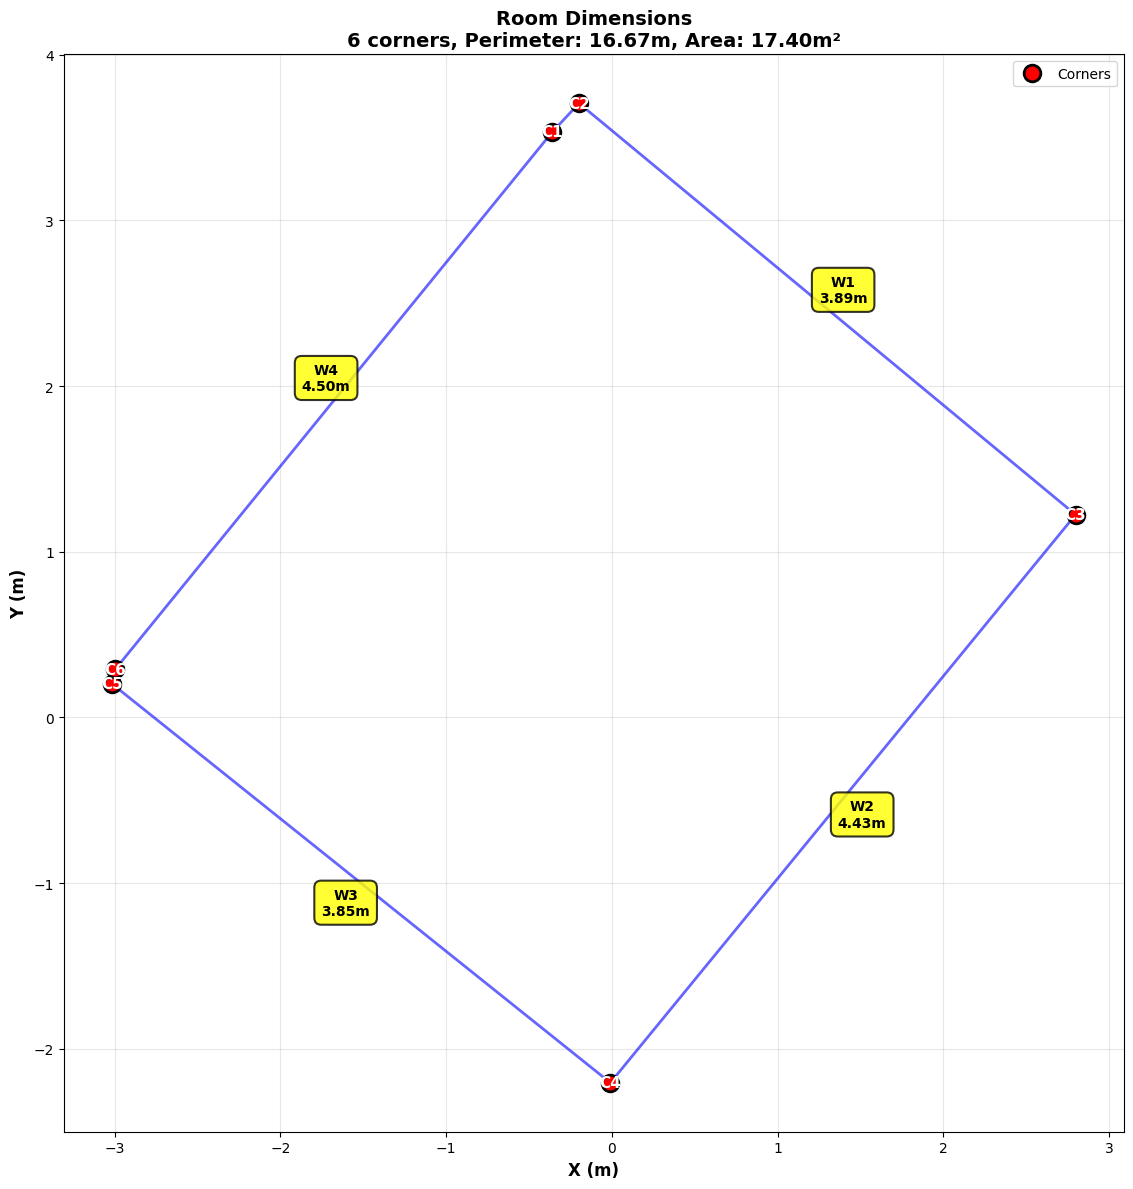

In [81]:
visualize_polygon_dimensions(Polygon(simplified_points), merged_dimensions)

In [196]:
def extract_accurate_floorplan(wall_points, 
                               concave_ratio=0.05,
                               offset_distance=None,
                               merge_angle_tol=8.0,
                               merge_gap=0.15,
                               min_wall_length=0.30):
    """
    Optimized pipeline for accurate floorplan extraction
    NO simplification - just merging
    """
    
    # Step 1: Concave hull
    from shapely.geometry import MultiPoint
    import shapely
    
    multi_point = MultiPoint(wall_points[:, :2])
    boundary = shapely.concave_hull(multi_point, ratio=concave_ratio)
    
    # Step 2: Optional offset (if you computed wall thickness)
    if offset_distance:
        boundary = boundary.buffer(-offset_distance)
    
    # Step 3: Extract polygon points
    polygon_points = np.array(boundary.exterior.coords)[:-1]
    
    print(f"Boundary vertices: {len(polygon_points)}")
    
    # Step 4: Get initial dimensions
    dimensions = compute_polygon_dimensions(polygon_points)
    
    # Step 5: Merge (NO SIMPLIFICATION!)
    merged = merge_walls_complete(
        dimensions,
        angle_tolerance=merge_angle_tol,
        max_gap=merge_gap,
        min_wall_length=min_wall_length
    )
    
    return merged

In [201]:
final_walls = extract_accurate_floorplan(
    all_wall_points,
    concave_ratio=0.05,
    offset_distance=None
    merge_angle_tol=8.0,
    merge_gap=0.15,
    min_wall_length=0.30
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (646013276.py, line 4)

In [202]:
final_walls

[{'wall_id': 1,
  'start_point': array([-2.29901884, -0.90718542]),
  'end_point': array([0.5944672 , 2.25673579]),
  'length': np.float64(4.287500312248962),
  'angle': np.float64(47.55629362468778),
  'merged_from': [0, 1, 2],
  'num_segments': 3},
 {'wall_id': 2,
  'start_point': array([0.5944672 , 2.25673579]),
  'end_point': array([1.15673062, 1.97342183]),
  'length': np.float64(0.6296085675619869),
  'angle': np.float64(333.25732442882804)},
 {'wall_id': 3,
  'start_point': array([1.15673062, 1.97342183]),
  'end_point': array([1.41336144, 2.22209307]),
  'length': np.float64(0.3573468330965674),
  'angle': np.float64(44.097543625747484)},
 {'wall_id': 4,
  'start_point': array([1.41336144, 2.22209307]),
  'end_point': array([2.15330142, 1.55253048]),
  'length': np.float64(0.9979104347267863),
  'angle': np.float64(317.85844245250485)},
 {'wall_id': 5,
  'start_point': array([2.15330142, 1.55253048]),
  'end_point': array([1.77863717, 1.18636316]),
  'length': np.float64(0.5238

In [203]:
def extract_merged_wall_polygon(merged_walls):
    """
    Extract polygon with only merged wall endpoints
    (Removes intermediate vertices but keeps real corners)
    
    Returns:
    --------
    corner_points : np.ndarray (N, 2)
        Just the corners (merged wall endpoints)
    """
    
    # Collect unique corners
    corners = []
    
    for wall in merged_walls:
        corners.append(wall['start_point'])
    
    # Close polygon (last wall's end = first wall's start)
    corners = np.array(corners)
    
    print(f"\nExtracted {len(corners)} corners from {len(merged_walls)} walls")
    
    return corners


def visualize_final_dimensions(merged_walls):
    """
    Clean visualization of final wall dimensions
    """
    import matplotlib.pyplot as plt
    
    # Extract corners
    corners = extract_merged_wall_polygon(merged_walls)
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Draw polygon
    poly_closed = np.vstack([corners, corners[0]])
    ax.plot(poly_closed[:, 0], poly_closed[:, 1],
            'b-', linewidth=2, alpha=0.6)
    
    # Mark corners
    for i, corner in enumerate(corners):
        ax.plot(corner[0], corner[1], 'go', markersize=15,
                markeredgecolor='black', markeredgewidth=2)
        ax.text(corner[0], corner[1], f"C{i+1}",
                fontsize=11, fontweight='bold',
                ha='center', va='center', color='white')
    
    # Label walls with dimensions
    colors = plt.cm.tab10(np.linspace(0, 1, len(merged_walls)))
    
    for i, wall in enumerate(merged_walls):
        # Draw wall line (thick)
        ax.plot([wall['start_point'][0], wall['end_point'][0]],
                [wall['start_point'][1], wall['end_point'][1]],
                '-', color=colors[i], linewidth=6, alpha=0.7)
        
        # Dimension label
        mid_x = (wall['start_point'][0] + wall['end_point'][0]) / 2
        mid_y = (wall['start_point'][1] + wall['end_point'][1]) / 2
        
        # Offset perpendicular
        vec = wall['end_point'] - wall['start_point']
        length = np.linalg.norm(vec)
        if length > 0:
            vec_norm = vec / length
            perp = np.array([-vec_norm[1], vec_norm[0]])
            offset = 0.20  # 20cm
            label_x = mid_x + perp[0] * offset
            label_y = mid_y + perp[1] * offset
        else:
            label_x, label_y = mid_x, mid_y
        
        ax.text(label_x, label_y,
                f"W{wall['wall_id']}\n{wall['length']:.2f}m",
                fontsize=12, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.6',
                         facecolor='yellow', alpha=0.95,
                         edgecolor='black', linewidth=2))
    
    # Summary
    total_perim = sum(w['length'] for w in merged_walls)
    area = Polygon(corners).area
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=13, fontweight='bold')
    ax.set_title(f'Final Room Dimensions\n'
                f'{len(corners)} corners, {len(merged_walls)} walls\n'
                f'Perimeter: {total_perim:.2f}m, Area: {area:.2f}m²',
                fontsize=15, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


Extracted 11 corners from 11 walls


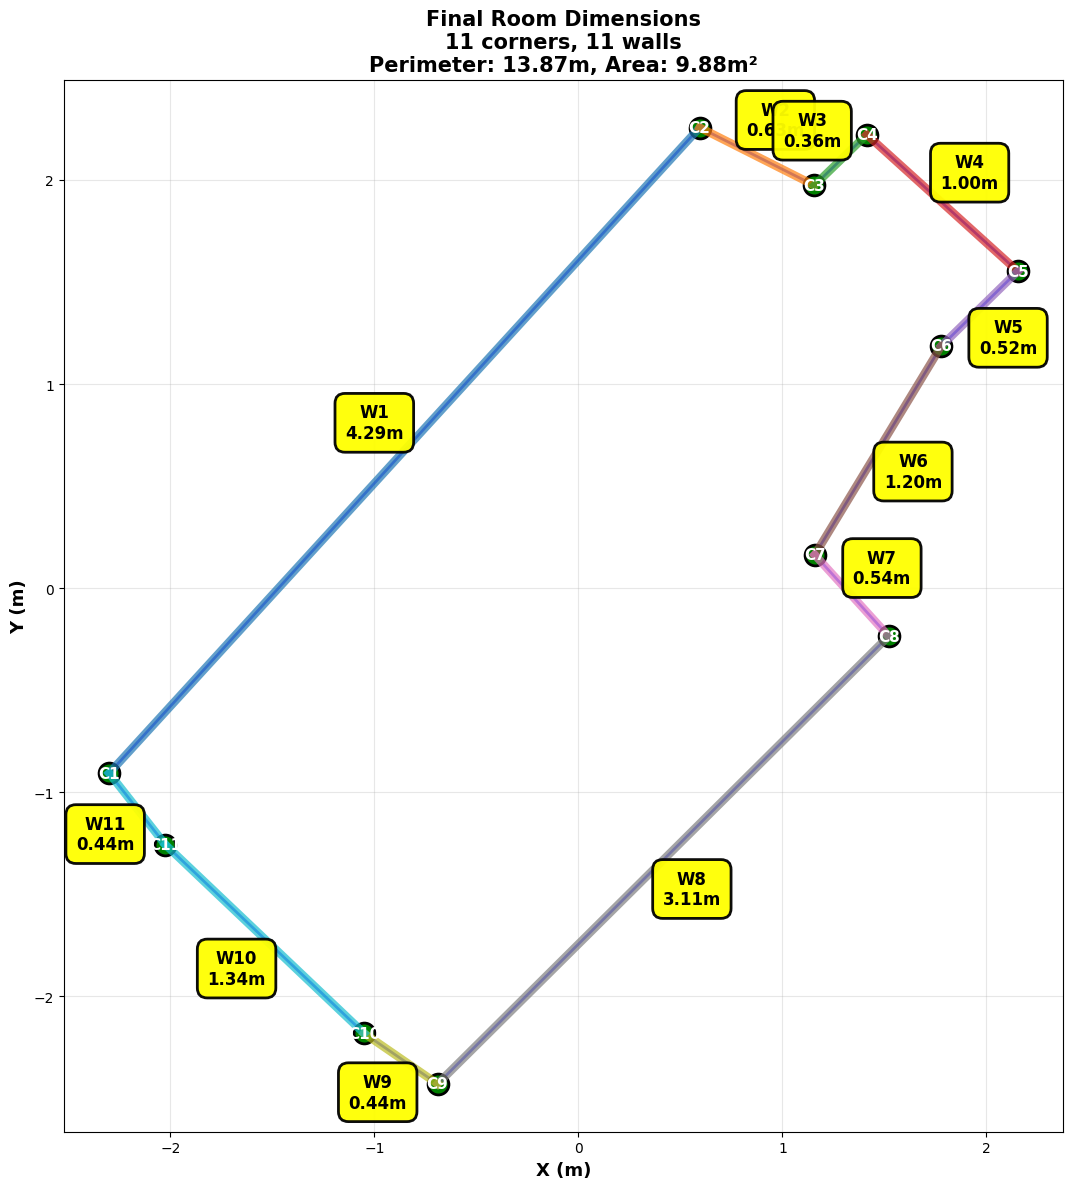

In [204]:
visualize_final_dimensions(final_walls)

In [74]:
import alphashape

In [75]:
def compute_concave_hull(points_2d, alpha=0.5):
    """
    Compute concave hull (alpha shape) of 2D points
    
    Args:
        points_2d: Nx2 numpy array of 2D points
        alpha: Alpha parameter controlling hull tightness
               - Smaller alpha (0.1-0.3): Tighter, more detailed hull (follows contours closely)
               - Medium alpha (0.5-0.8): Balanced
               - Larger alpha (1.0-2.0): Looser, more convex (smooths over gaps)
               - alpha → infinity: Becomes convex hull
    
    Returns:
        hull_polygon: Shapely Polygon object, or None if failed
    """
    
    print(f"\nComputing concave hull with alpha={alpha}...")
    print(f"Input: {len(points_2d)} points")
    
    try:
        # Compute alpha shape
        hull = alphashape.alphashape(points_2d, alpha)
        
        # Check result type
        if hull is None or hull.is_empty:
            print("Warning: Hull computation returned empty result")
            return None
        
        # Handle MultiPolygon (disconnected regions)
        if hull.geom_type == 'MultiPolygon':
            print(f"Warning: Got MultiPolygon with {len(list(hull.geoms))} parts")
            # Take the largest polygon
            polygons = list(hull.geoms)
            hull = max(polygons, key=lambda p: p.area)
            print(f"Selected largest polygon (area={hull.area:.2f} m²)")
        
        # Get hull info
        num_vertices = len(hull.exterior.coords) - 1  # -1 because first=last
        
        print(f"✓ Hull computed successfully")
        print(f"  Vertices: {num_vertices}")
        print(f"  Area: {hull.area:.2f} m²")
        print(f"  Perimeter: {hull.length:.2f} m")
        
        return hull
    
    except Exception as e:
        print(f"Error computing hull: {e}")
        return None

In [77]:
hull = compute_concave_hull(wall_points_2d)


Computing concave hull with alpha=0.5...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 149
  Area: 12.33 m²
  Perimeter: 14.11 m


In [78]:
def visualize_hull(points_2d, hull_polygon, title="Concave Hull", downsample=10):
    """
    Visualize 2D points with hull overlay
    
    Args:
        points_2d: Nx2 numpy array of original points
        hull_polygon: Shapely Polygon from compute_concave_hull
        title: Plot title
        downsample: Downsample points for faster plotting
    """
    if hull_polygon is None:
        print("No hull to visualize")
        return
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    # Extract hull vertices
    hull_coords = np.array(hull_polygon.exterior.coords)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot points
    ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
               s=1, c='lightblue', alpha=0.3, label='Wall points')
    
    # Plot hull
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'r-', linewidth=2, label='Concave hull')
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'ro', markersize=4, label='Hull vertices')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization info:")
    print(f"  Plotted {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    print(f"  Hull has {len(hull_coords)-1} vertices")

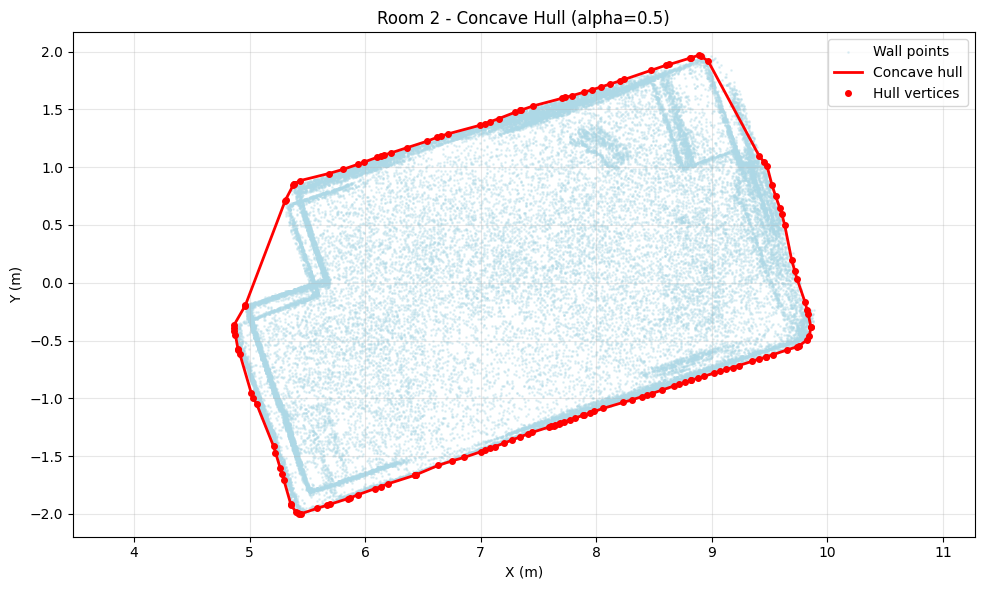


Visualization info:
  Plotted 42699 points (downsampled from 426989)
  Hull has 149 vertices


In [79]:
visualize_hull(points_2d, hull, title="Room 2 - Concave Hull (alpha=0.5)")

In [80]:
def compare_alpha_values(points_2d, alpha_values=[0.3, 0.5, 0.8, 1.0], downsample=10):
    """
    Compare different alpha values side-by-side
    
    Args:
        points_2d: Nx2 numpy array
        alpha_values: List of alpha values to test
        downsample: Downsample for plotting
    """
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    num_alphas = len(alpha_values)
    fig, axes = plt.subplots(1, num_alphas, figsize=(6*num_alphas, 6))
    
    if num_alphas == 1:
        axes = [axes]
    
    for i, alpha in enumerate(alpha_values):
        ax = axes[i]
        
        # Compute hull
        hull = compute_concave_hull(points_2d, alpha=alpha)
        
        if hull is not None:
            # Plot points
            ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                      s=1, c='lightblue', alpha=0.3)
            
            # Plot hull
            hull_coords = np.array(hull.exterior.coords)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'r-', linewidth=2)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'ro', markersize=3)
            
            ax.set_title(f'Alpha = {alpha}\n{len(hull_coords)-1} vertices, '
                        f'Area = {hull.area:.2f} m²')
        else:
            ax.set_title(f'Alpha = {alpha}\n(failed)')
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Computing concave hull with alpha=0.05...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 51
  Area: 12.42 m²
  Perimeter: 14.10 m


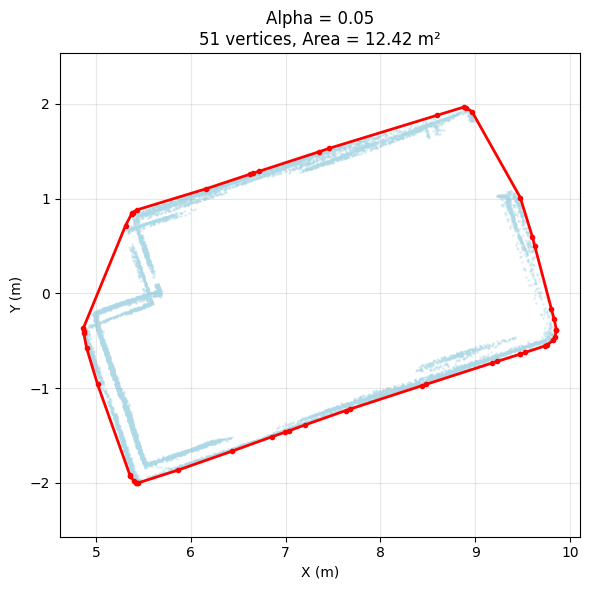

In [83]:
compare_alpha_values(wall_points_2d, alpha_values=[0.05])

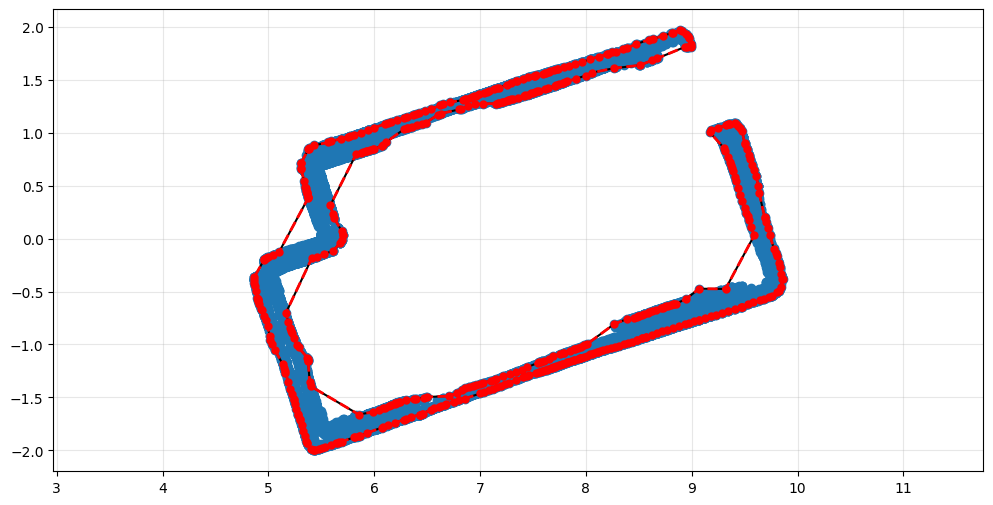

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

# Get alpha shape
alpha_hull = alpha_shape(wall_points_2d, alpha=0.4)

if alpha_hull.geom_type == 'Polygon':
    x, y = alpha_hull.exterior.xy
    coords = np.array(list(zip(x, y)))
    
    # Plot edges
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    
    # Plot vertices
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [84]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [85]:
voxel_down_pcd = sem_seg.pcd

In [ ]:
(voxel_down_pcd.select_by_index(ind))

PointCloud with 410042 points.

In [91]:
cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
display_inlier_outlier(voxel_down_pcd, ind)

Showing outliers (red) and inliers (gray): 


In [94]:
o3d.visualization.draw_geometries([cl])

### pointnet

In [16]:
predictions = sem_seg.pointnet_segmentation(sem_seg.points, type='all')

In [17]:
sem_seg.visualize_segments(predictions)

PointCloud with 891428 points.

In [20]:
sem_seg.classes["ceiling"]

0

In [21]:
ceiling_mask = predictions == sem_seg.classes["ceiling"]
wall_mask = predictions == sem_seg.classes["wall"]
door_mask = predictions == sem_seg.classes["door"]
window_mask = predictions == sem_seg.classes["window"]

ceiling_points_2d = points_2d[ceiling_mask]
wall_points_2d = points_2d[wall_mask]
door_points_2d = points_2d[door_mask]
window_points_2d = points_2d[window_mask]

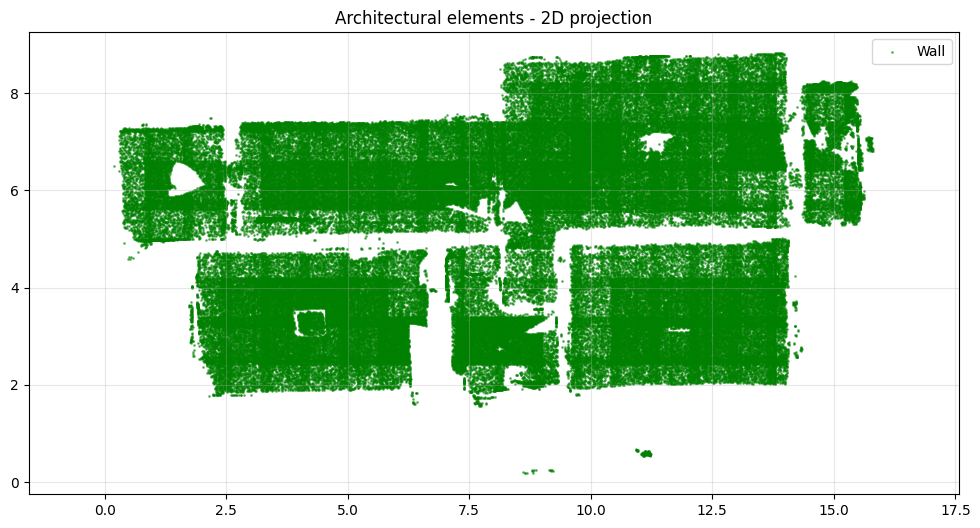

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Wall', alpha=0.5)
# plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [116]:
clustering = DBSCAN(eps=0.1, min_samples=5, n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [121]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 16


In [122]:
ceiling_clusters

array([0, 0, 0, ..., 1, 1, 1], shape=(124351,))

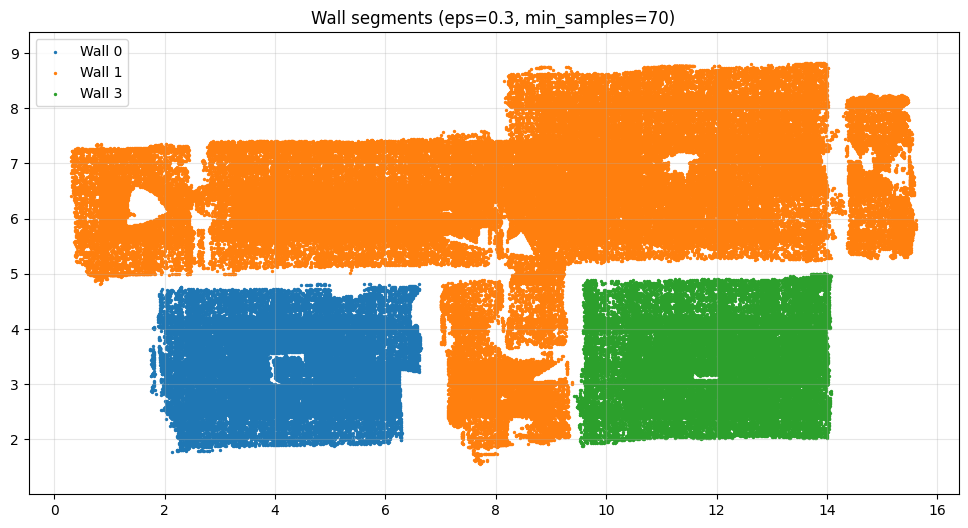

In [133]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 300:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()
plt.title(f'Wall segments (eps=0.3, min_samples=70)')
plt.grid(True, alpha=0.3)
plt.show()

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

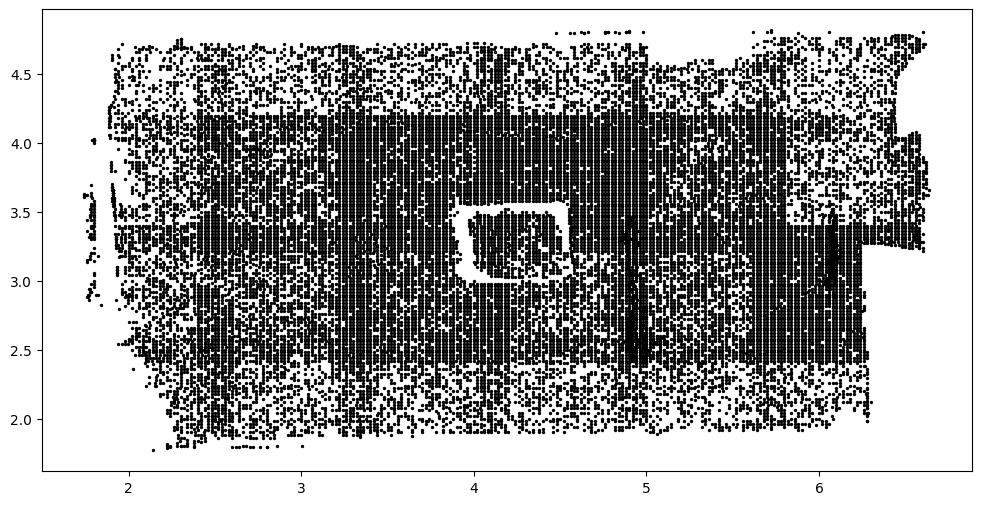

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [131]:
sum(mask)

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


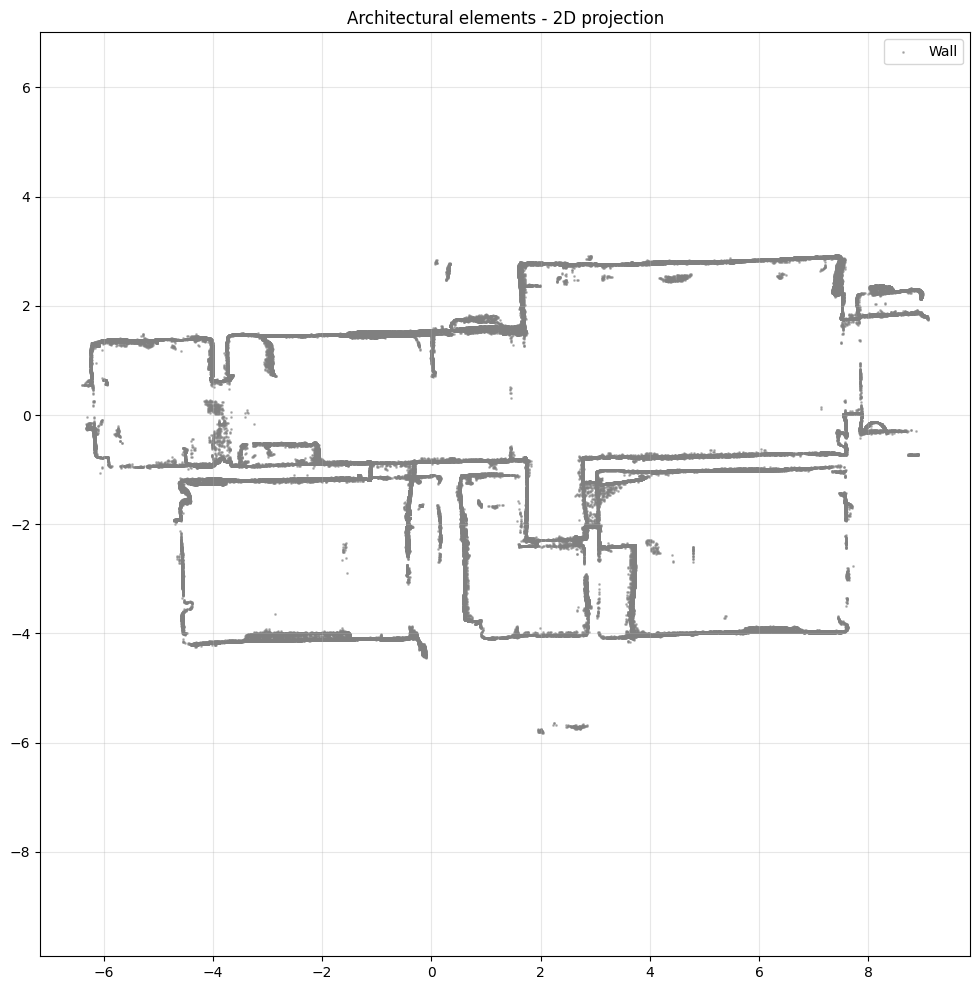

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

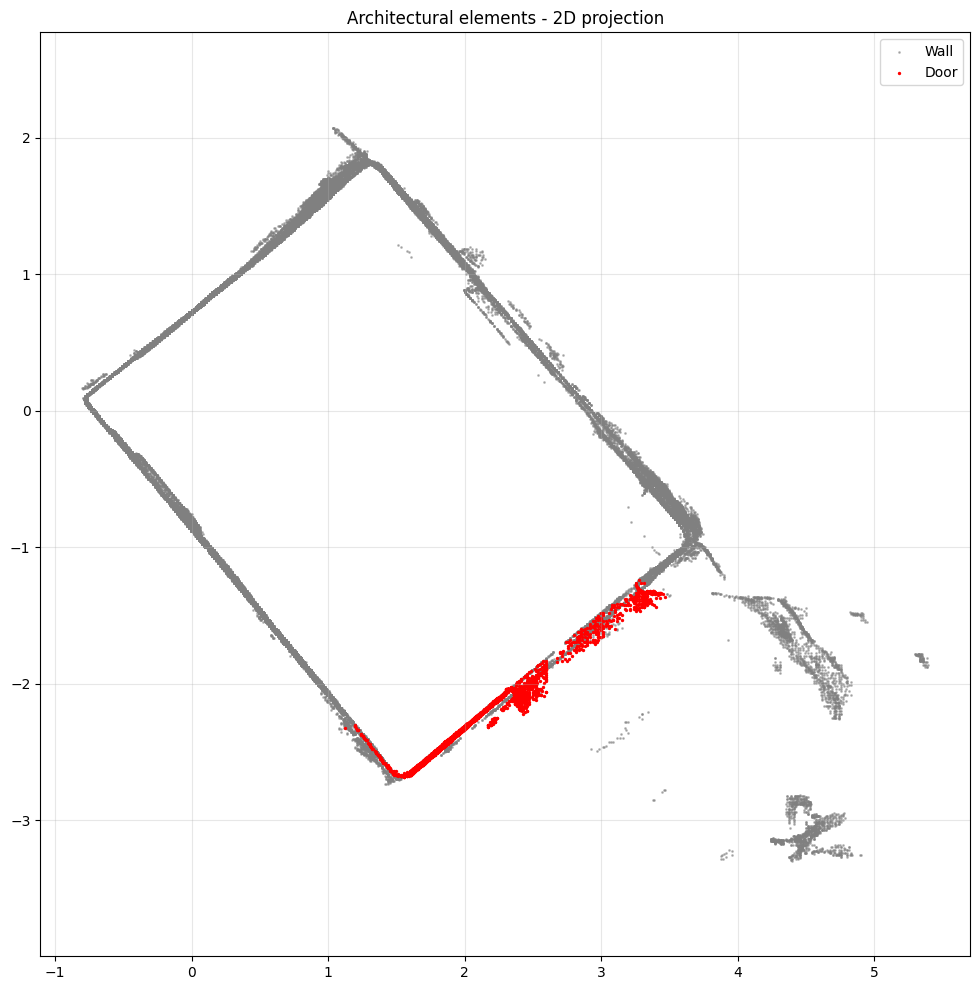

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()